# Performance comparison

In [1]:
import cudf
import pandas as pd
import numpy as np
import time
from io import BytesIO
import os
import timeit
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)

In [3]:
pdf = pd.DataFrame({
    "numbers": np.random.randint(-1000, 1000, 300_000_000, dtype='int64'),
    "business": np.random.choice(["McD", "Buckees", "Walmart", "Costco"], size=300_000_000)
})
pdf

,numbers,business
0,-316,Costco
1,-441,Costco
2,653,Buckees
3,216,Buckees
4,-165,Walmart
...,...,...
299999995,-395,Walmart
299999996,-653,Buckees
299999997,364,Buckees
299999998,159,Buckees


In [4]:
gdf = cudf.from_pandas(pdf)
gdf

,numbers,business
0,-316,Costco
1,-441,Costco
2,653,Buckees
3,216,Buckees
4,-165,Walmart
...,...,...
299999995,-395,Walmart
299999996,-653,Buckees
299999997,364,Buckees
299999998,159,Buckees


In [7]:
def bench(pd_obj, gd_obj, func, **kwargs):
    pd_time = timeit.timeit(lambda : func(pd_obj), **kwargs)
    gd_time = timeit.timeit(lambda : func(gd_obj), **kwargs)
    return pd_time, gd_time

In [6]:
pandas_value_counts, cudf_value_counts = bench(pdf, gdf, lambda df : df.value_counts(), number=30)

In [7]:
pdf = pdf.head(100_000_000)
gdf = gdf.head(100_000_000)

In [8]:
pandas_concat = timeit.timeit(lambda : pd.concat([pdf, pdf, pdf]), number=30)

In [9]:
cudf_concat = timeit.timeit(lambda : cudf.concat([gdf, gdf, gdf]), number=30)

In [10]:
pandas_groupby, cudf_groupby = bench(pdf, gdf, lambda df : df.groupby("business").agg(["min", "max", "mean"]), number=30)

In [11]:
pdf = pd.DataFrame({
    "numbers": np.random.randint(-1000, 1000, 1_000_000, dtype='int64'),
    "business": np.random.choice(["McD", "Buckees", "Walmart", "Costco"], size=1_000_000)
})
gdf = cudf.from_pandas(pdf)

In [12]:
pandas_merge, cudf_merge = bench(pdf, gdf, lambda df: df.merge(df), number=30)

In [13]:
perf_df = pd.DataFrame(
    {
        "cudf speed up v/s pandas": [pandas_value_counts/cudf_value_counts, pandas_concat/cudf_concat, pandas_groupby/cudf_groupby, pandas_merge/cudf_merge],
}, index=["value_counts", "concat", "groupby", "merge"])

In [17]:
perf_df

,cudf speed up v/s pandas
value_counts,282.901300
concat,203.624680
groupby,138.495762
merge,136.519031


## Concat, count & joins performance

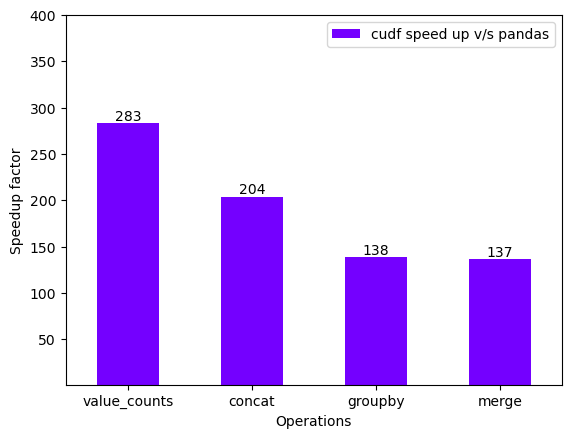

In [20]:
ax = perf_df.plot.bar(color='#7400ff', ylim=(1, 400), rot=0, xlabel="Operations", ylabel="Speedup factor")
ax.bar_label(ax.containers[0], fmt='%.0f')
plt.show()

In [21]:
# Cleaning up used memory for later benchmarks
del pdf
del gdf

In [22]:
pd_series = pd.Series(np.random.choice(["123", "56.234", "Walmart", "Costco", "rapids ai"], size=300_000_000))

In [23]:
gd_series = cudf.from_pandas(pd_series)

In [25]:
pandas_upper, cudf_upper = bench(pd_series, gd_series, lambda s: s.str.upper(), number=20)

In [28]:
pandas_contains, cudf_contains = bench(pd_series, gd_series, lambda s: s.str.contains(r"[0-9][a-z]"), number=20)

In [26]:
pandas_isalpha, cudf_isalpha = bench(pd_series, gd_series, lambda s: s.str.isalpha(), number=20)

In [29]:
perf_df = pd.DataFrame(
    {
        "cudf speed up v/s pandas": [pandas_upper/cudf_upper, pandas_contains/cudf_contains, pandas_isalpha/cudf_isalpha],
    },
    index=["upper", "contains", "is_alpha"]
)

In [30]:
perf_df

,cudf speed up v/s pandas
upper,1832.120875
contains,1311.758332
is_alpha,5752.301339


## Strings Performance

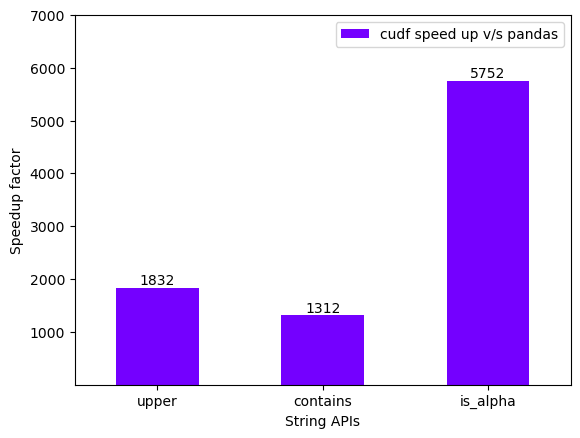

In [33]:
ax = perf_df.plot.bar(color='#7400ff', ylim=(1, 7000), rot=0, xlabel="String APIs", ylabel="Speedup factor")
ax.bar_label(ax.containers[0], fmt='%.0f')
plt.show()

In [3]:
size = 10_000_000
pdf_age = pd.DataFrame({
    'age': np.random.randint(0,100,size),
})
pdf_age

,age
0,44
1,47
2,64
3,67
4,67
...,...
9999995,92
9999996,99
9999997,36
9999998,27


In [4]:
gdf_age = cudf.from_pandas(pdf_age)
gdf_age

,age
0,44
1,47
2,64
3,67
4,67
...,...
9999995,92
9999996,99
9999997,36
9999998,27


In [5]:
def age_udf(row):
    if row['age'] < 18:
        return 0
    elif 18 <= row['age'] < 20:
        return 1
    elif 20 <= row['age'] < 30:
        return 2
    elif 30 <= row['age'] < 40:
        return 3
    elif 40 <= row['age'] < 50:
        return 4
    elif 50 <= row['age'] < 60:
        return 5
    elif 60 <= row['age'] < 70:
        return 6
    else:
        return 7

In [8]:
pandas_int_udf, cudf_int_udf = bench(pdf_age, gdf_age, lambda df: df.apply(age_udf, axis=1), number=1)

In [9]:
def str_isupper_udf(row):
    if row.isupper():
        return 0
    else:
        return 1

In [10]:
pd_series = pd.Series(np.random.choice(["ABC", "abc", "hello world", "AI"], size=100_000_000), name='strings')
pd_series

0                    AI
1                   ABC
2           hello world
3                   abc
4           hello world
               ...     
99999995             AI
99999996             AI
99999997            abc
99999998            abc
99999999    hello world
Name: strings, Length: 100000000, dtype: object

In [11]:
gd_series = cudf.from_pandas(pd_series)
gd_series

0                    AI
1                   ABC
2           hello world
3                   abc
4           hello world
               ...     
99999995             AI
99999996             AI
99999997            abc
99999998            abc
99999999    hello world
Name: strings, Length: 100000000, dtype: object

In [12]:
pandas_str_udf, cudf_str_udf = bench(pd_series, gd_series, lambda s: s.apply(str_isupper_udf), number=1)

In [13]:
size = 100_000_000
pdf = pd.DataFrame()
pdf['key'] = np.random.randint(0,2,size)
pdf['val'] = np.random.randint(0,7,size)


def custom_formula_udf(df):
  df['out'] = df['key'] * df['val'] - 10
  return df


gdf = cudf.from_pandas(pdf)

In [14]:
pandas_udf_groupby, cudf_udf_groupby = bench(pdf, gdf, lambda df: df.groupby(['key']).apply(custom_formula_udf), number=1)

/tmp/ipykernel_1761/3385942998.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  pandas_udf_groupby, cudf_udf_groupby = bench(pdf, gdf, lambda df: df.groupby(['key']).apply(custom_formula_udf), number=1)


In [15]:
perf_df = pd.DataFrame(
    {
    "cudf speed up v/s pandas": [pandas_int_udf/cudf_int_udf, 
                                 pandas_str_udf/cudf_str_udf,
                                 pandas_udf_groupby/cudf_udf_groupby],
}, index=["int_udf", 
          "str_udf",
          "groupby_udf"])

In [16]:
perf_df

,cudf speed up v/s pandas
int_udf,362.091673
str_udf,204.865789
groupby_udf,458.435114


## UDF performance (with JIT overhead)

The first UDF runs include JIT compilation overhead, due to which the performance of 1st run and average of next few runs are compared separately.

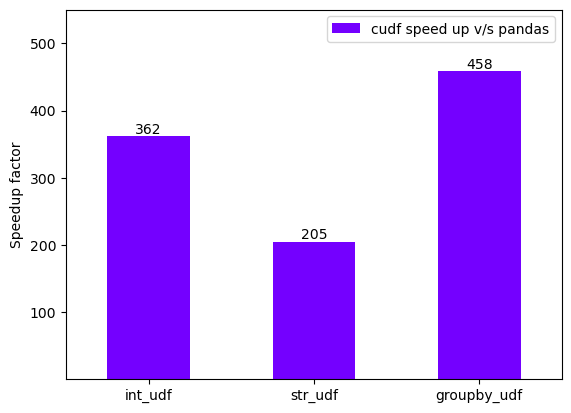

In [17]:
ax = perf_df.plot.bar(color='#7400ff', ylim=(1,550), rot=0, label="UDFs", ylabel="Speedup factor")
ax.bar_label(ax.containers[0], fmt='%.0f')
plt.show()

In [18]:
pandas_int_udf, cudf_int_udf = bench(pdf_age, gdf_age, lambda df: df.apply(age_udf, axis=1), number=10)

In [19]:
pandas_str_udf, cudf_str_udf = bench(pd_series, gd_series, lambda s: s.apply(str_isupper_udf), number=10)

In [20]:
pandas_udf_groupby, cudf_udf_groupby = bench(pdf, gdf, lambda df: df.groupby(['key']).apply(custom_formula_udf), number=10)

/tmp/ipykernel_1761/1796019312.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  pandas_udf_groupby, cudf_udf_groupby = bench(pdf, gdf, lambda df: df.groupby(['key']).apply(custom_formula_udf), number=10)
/tmp/ipykernel_1761/1796019312.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  pandas

In [21]:
perf_df = pd.DataFrame(
    {
    "cudf speed up v/s pandas": [pandas_int_udf/cudf_int_udf, 
                                 pandas_str_udf/cudf_str_udf,
                                 pandas_udf_groupby/cudf_udf_groupby],
}, index=["int_udf", 
          "str_udf",
          "groupby_udf"])

In [31]:
perf_df

,cudf speed up v/s pandas
int_udf,95448.144630
str_udf,2587.570338
groupby_udf,415.460546


## UDF performance (without JIT overhead)

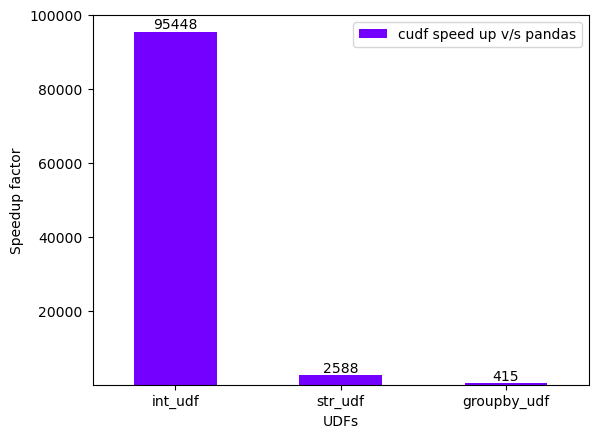

In [32]:
ax = perf_df.plot.bar(color='#7400ff', ylim=(1, 100000), rot=0, xlabel="UDFs", ylabel="Speedup factor")
ax.bar_label(ax.containers[0],  fmt='%.0f')
plt.show()

# System Configuration

## CPU Configuration

In [78]:
!lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          80
On-line CPU(s) list:             0-79
Thread(s) per core:              2
Core(s) per socket:              20
Socket(s):                       2
NUMA node(s):                    2
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           85
Model name:                      Intel(R) Xeon(R) Gold 6230 CPU @ 2.10GHz
Stepping:                        7
CPU MHz:                         800.049
CPU max MHz:                     3900.0000
CPU min MHz:                     800.0000
BogoMIPS:                        4200.00
Virtualization:                  VT-x
L1d cache:                       1.3 MiB
L1i cache:                       1.3 MiB
L2 cache:                        40 MiB
L3 cache:                     

## GPU Configuration

In [79]:
!nvidia-smi

Mon Feb  6 17:43:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.04    Driver Version: 525.60.04    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  H100 80GB HBM2e     On   | 00000000:1E:00.0 Off |                    0 |
| N/A   30C    P0    60W / 700W |      0MiB / 81559MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  H100 80GB HBM2e     On   | 00000000:22:00.0 Off |                    0 |
| N/A   